# StatsJam: Missing Data 
##### Sami Hamdan

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
import seaborn as sns

# Why is this important: 
We want to preserve the information of the (non-)missing data,  
but avoid lowerering samples size or the introduction of biases

**Important**: the reason for missingness determines how to handle them!

In [2]:
#skill = np.random.normal(size = 500)
np.random.seed(1)
n = 1000
income_male = np.random.normal(size = int(n/2)) + 2
income_female = np.random.normal(size = int(n/2)) 
income = np.concatenate((income_male, income_female))
gender = np.array([0]*int(n/2) + [1]*int(n/2))
noise = np.random.normal(size = n)

happiness = 0.75 * income + noise

df = pd.DataFrame({
    'income': income,
    'happiness': happiness,
    'gender': gender
})
df.head()

,income,happiness,gender
0,3.624345,2.565023,0
1,1.388244,-1.391326,0
2,1.471828,1.611856,0
3,0.927031,0.371241,0
4,2.865408,0.637979,0


In [3]:
def impute_random(arr_in): 
    arr = arr_in.copy() # to not change the input
    arr_is_nan = np.isnan(arr) # 1 if nan else 0
    n_nan = sum(arr_is_nan)
    arr_without_nan = arr[arr_is_nan==False] 
    arr_fill = np.random.choice(arr_without_nan, size=n_nan)
    arr[arr_is_nan] = arr_fill
    return arr

# 1) Missingness completely at random (MCAR)

Reason for missing: unrelated to **any** characteristics/responses of subject   
Handling: complete-case analysis (Dropping) allowed,  
          imputation better estimation  
How common: very rare 
Assessing assumption: same dist in y for x complete vs x uncomplete

In [4]:
df_mcar = df.copy()
chosen_values = np.random.choice(
    a=[False,True], size=len(df_mcar), p=[0.8, 0.2])  # selector for nans later
df_mcar.loc[chosen_values,'income'] = np.nan # adding nans to the selected/chosen values

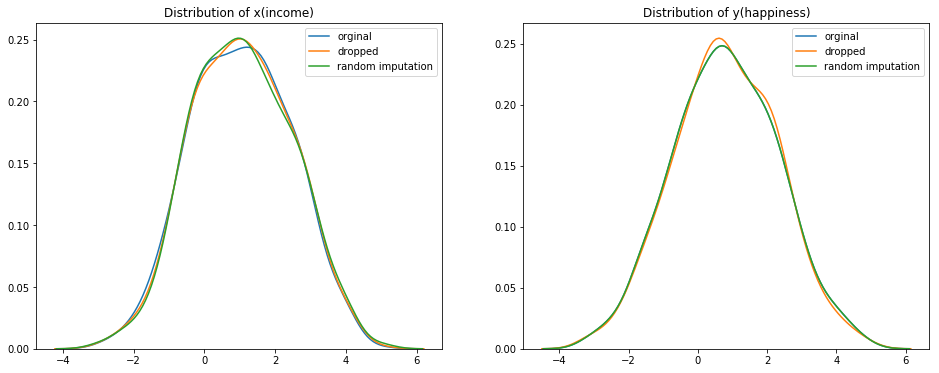

In [5]:
fig, ax = plt.subplots(1,2,figsize=[16,6])

sns.kdeplot(df.income, label='orginal', ax=ax[0])
sns.kdeplot(df_mcar.dropna().loc[:,'income'], label='dropped', ax=ax[0])
sns.kdeplot(impute_random(df_mcar.income), label='random imputation', ax=ax[0])
ax[0].set_title('Distribution of x(income)')

sns.kdeplot(df.happiness, label='orginal', ax=ax[1])
sns.kdeplot(df_mcar.dropna().loc[:,'happiness'], label='dropped', ax=ax[1])
sns.kdeplot(impute_random(df_mcar.happiness), label='random imputation', ax=ax[1])
ax[1].set_title('Distribution of y(happiness)')

None

# 2) Missing at random (MAR) 

Reason for missing: depends **only** on the observed data (not on unobserved)   
Handling: imputation needed basted on observed data   
How common: very common  
Problem: We usually cannot know it does not depend on unobserved as well!  

### Example:
Same data as before, but this time only men have missing values!  

In [6]:
# excluding data:
df_mar = df.copy()
chosen_values = np.random.choice(
    a=[False,True], size=int(len(df_mar)/2), p=[0.6, 0.4]) # as many values are missing as before but only in men
chosen_values = np.concatenate((chosen_values, [False]*int(n/2)))
df_mar.loc[chosen_values,'income'] = np.nan

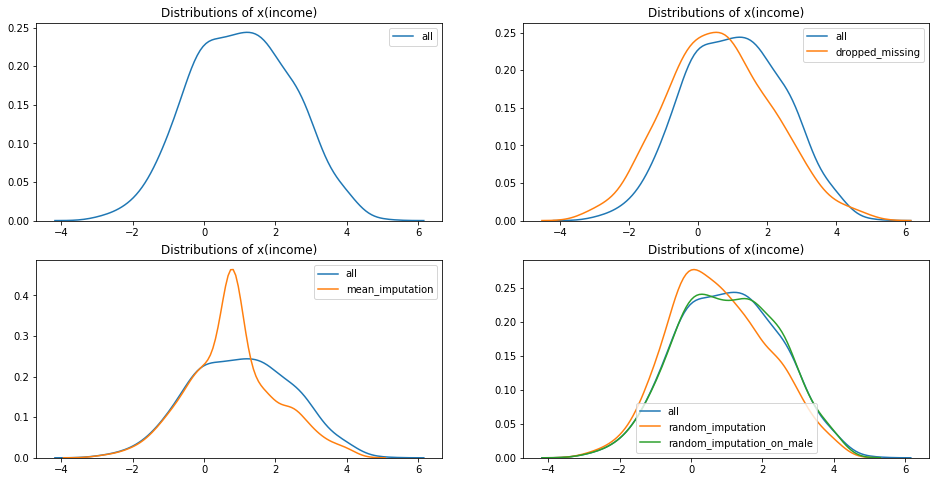

In [7]:
# plotting:
fig, ax = plt.subplots(2,2,figsize=[16,8])
[sns.kdeplot(df.income, label='all', ax=ax[i][ii])
 for i in range(2)
 for ii in range(2)
]
sns.kdeplot(df_mar.dropna().happiness,
            label='dropped_missing', ax=ax[0][1])
sns.kdeplot(df_mar.income.fillna(
    df_mar.income.mean()), label='mean_imputation', ax=ax[1][0])
sns.kdeplot(impute_random(df_mar.income.values),
            label = 'random_imputation',
            ax = ax[1][1])

# adding imputation but only for men -> because they have missing values
impute_on_male = df_mar.loc[df_mar.gender==0].loc[:,'income']
impute_on_male = impute_random(impute_on_male.values)
impute_on_male = np.concatenate(
    (impute_on_male, df_mar.loc[df_mar.gender==1].loc[:,'income'].values))

df_imputed = df_mar.copy()
df_imputed.income = impute_on_male
sns.kdeplot(df_imputed.income,
            label = 'random_imputation_on_male',
            ax = ax[1][1])

[one_ax.set_title('Distributions of x(income)') 
 for rows in ax 
 for one_ax in rows]
None

###### Effect on the variables with missing values:  
* dropping the rows (Complete-case analysis):  
    creates a systematic bias =>  missing values are only in men and these have higher values for income in general.  
* Using the mean for imputation => changes the variables distribution drastically! 
* Random imputation (not dependant on gender) => similar to dropping rows
* Random imputation dependant on gender (prediction) => best result, distribution close to the original


###### WARNING:
There is also an effect of dropping rows on the y (happiness):

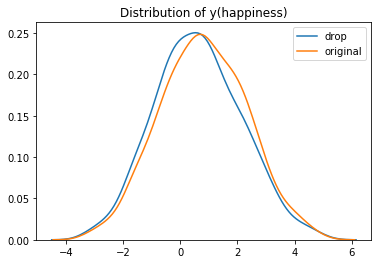

In [8]:
# plotting for y
sns.kdeplot(df_mar.dropna().happiness, label='drop')
sns.kdeplot(df.happiness, label='original')
plt.title('Distribution of y(happiness)')
None

=> dropping rows also distorts the distribution of y itself! 
This should be prevented!  

# 3) Missing Not At Random (MNAR)

### A) Nonresponse 
Reason for missing: the missing values themselves realte to the reson of missing  
Examples: 
* Depession -> to depressed to continue study
* very Low/High Income -> don't want to tell 

Handling: Difficult.   
* Sometimes: Using model which can use NaNs for prediction,  
* Most of the time: External considerations

### B) Unorthodox 
Reason for missing: other unobserved variables.  
Handling: We need to observe them, then we can use them for imputation.  







##### Problem: finding out that MNAR is happening  

# Characterize patterns of missingness

We can use exploratory tools: Logistic regression, random forest, clustering!  

Example: Logistic regression to predict whether a value is missing or not given other columns. If so assuming MAR is plausible => imputation using prediction

#  Imputation: 

* Mean Imputation: often biases => correlation towards zero     
* Median (Modes) Imputation: uses at least actual values from variable  
* Simple Random Imputation: keeps distribution from all **non missing** values   
* Supervised estimators: complete column -> uncomple column. Adding of randomness to keep variation in predicted values.  
* Different iterative Versions of Imputation:  
    You can fill the missing columns with preleminary values -> predict other columns and vice versa. Then use the predicted instead of preleminary values.  
